<a href="https://colab.research.google.com/github/ravishelnaicker/Network-Architecture/blob/main/Network_Architure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 3.6 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/nasim/envs/render.py:17: UserWarning: Unable to import Matplotlib with TkAgg backend due to following exception: "<class 'ImportError'> Cannot load backend 'TkAgg' which requires the 'tk' interactive framework, as 'headless' is currently running". NASIM can still run but GUI functionallity may not work as expected.
  warnings.warn(


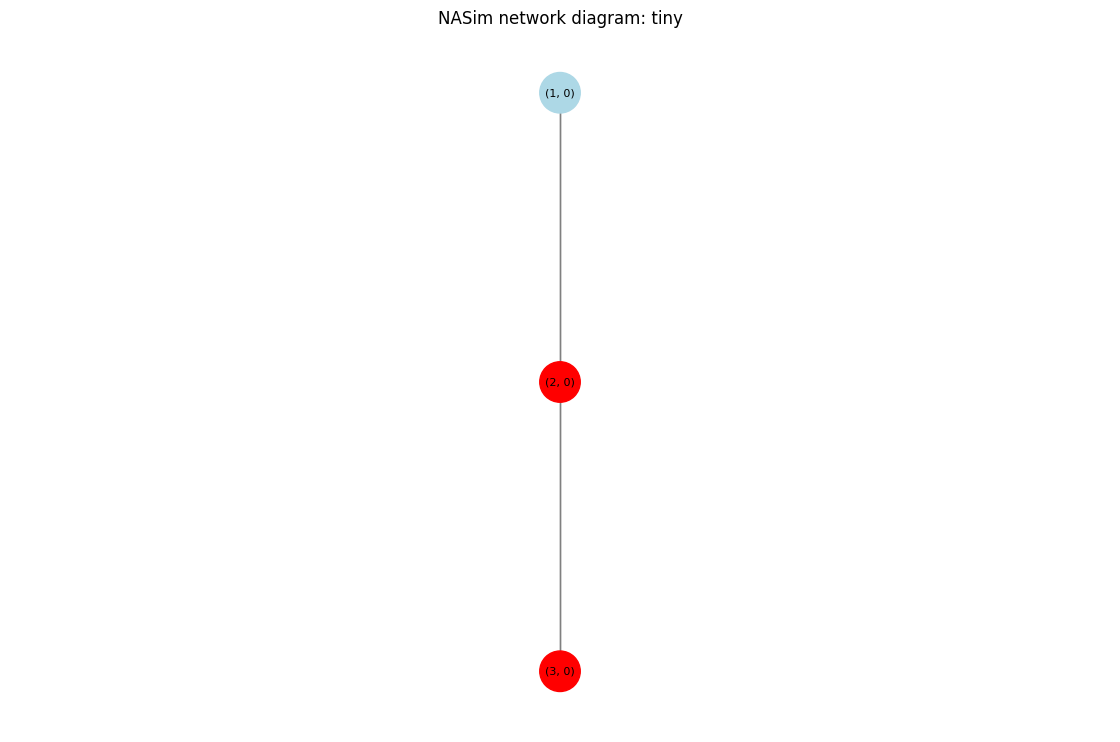

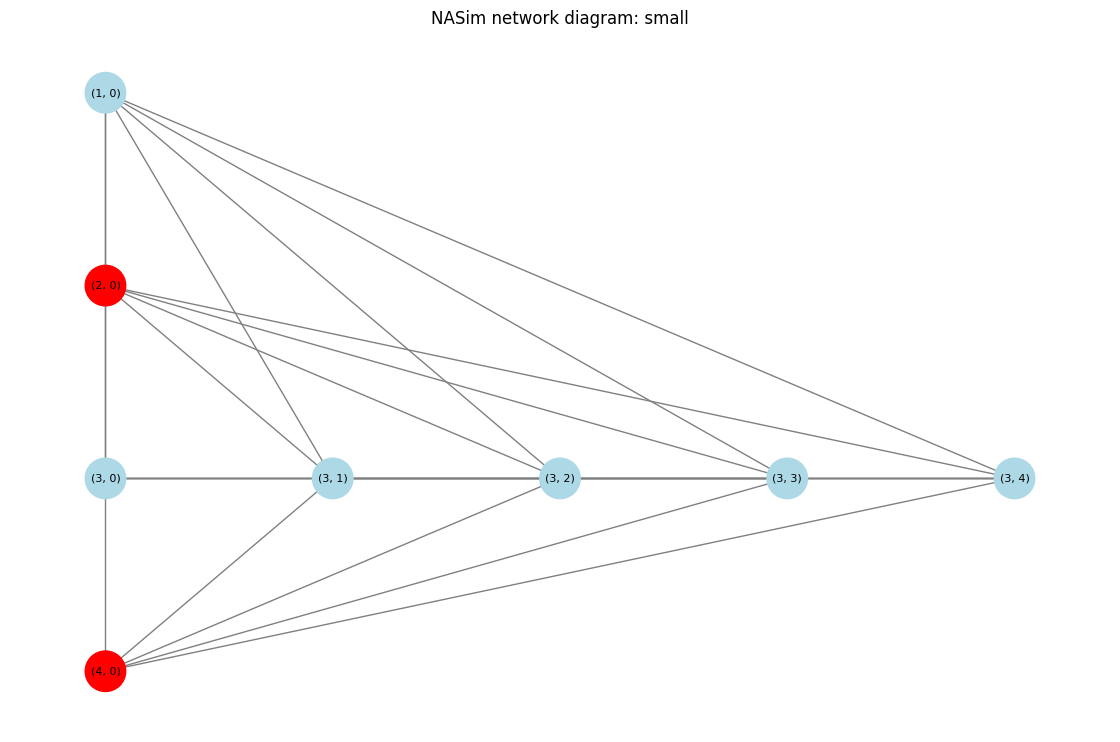

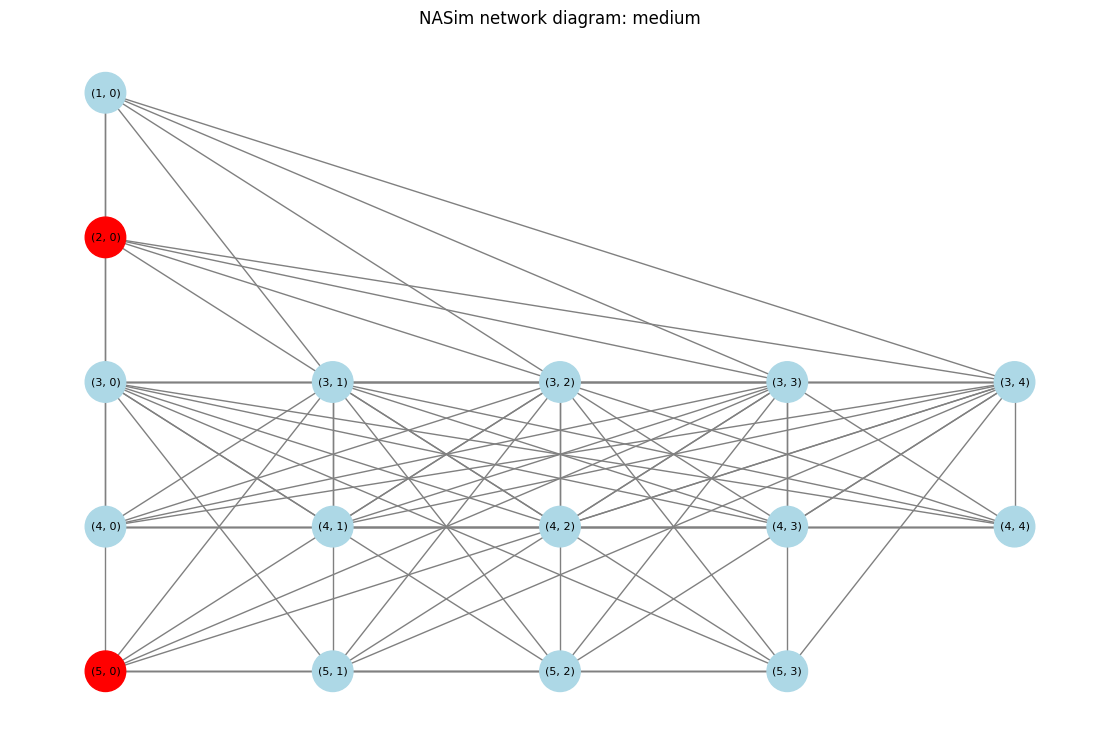

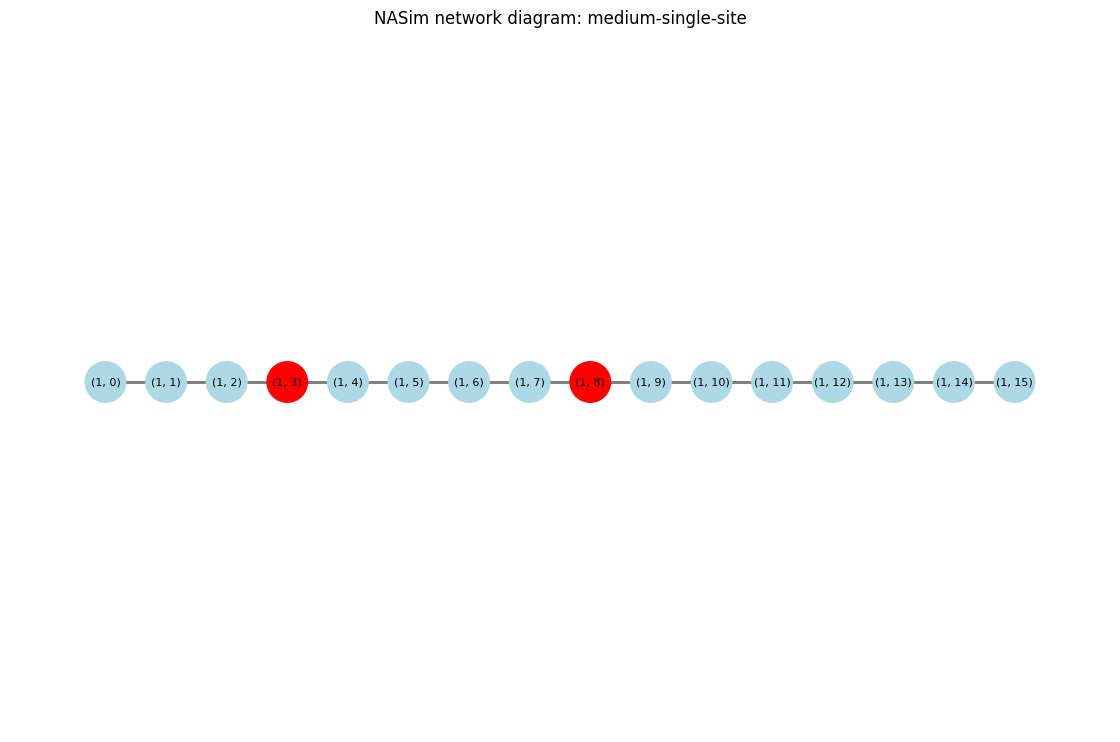

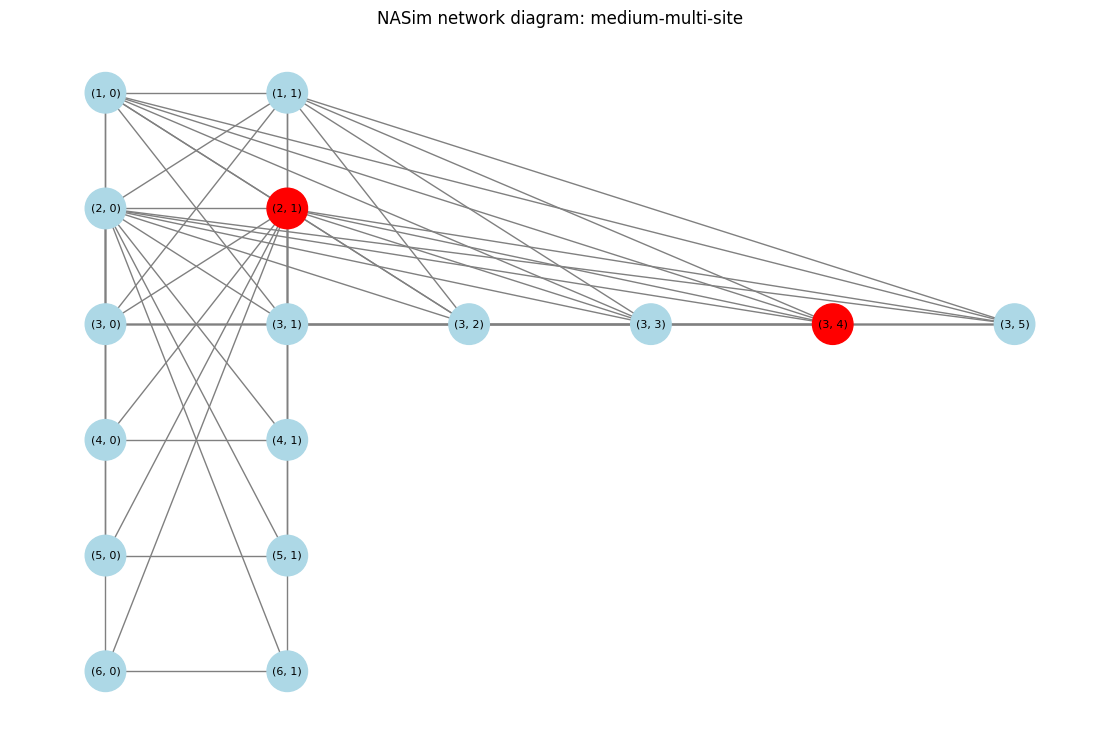

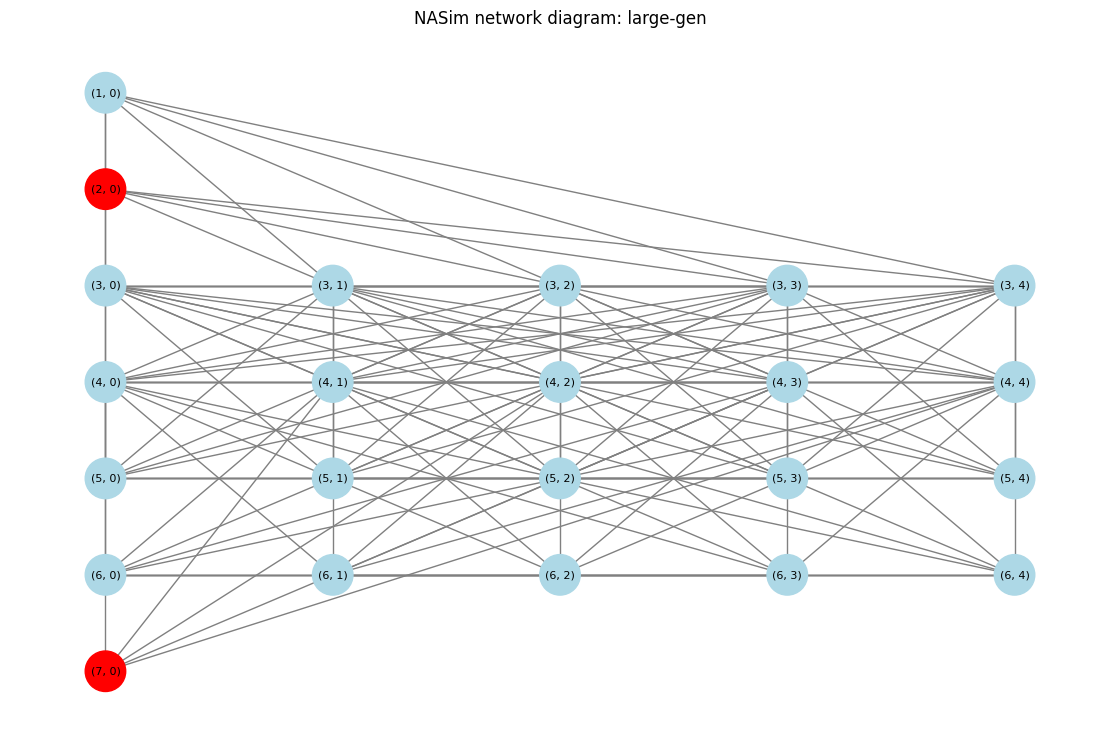

In [ ]:
# Draw NASim network diagrams for multiple benchmarks (tiny → large-gen)
# Requires: nasim, networkx, matplotlib
!pip install nasim
!pip install networkx matplotlib

import nasim
import networkx as nx
import matplotlib.pyplot as plt

# ---- Pick which environments to render ----
ENVIRONMENTS = [
    "tiny",
    "small",
    "medium",
    "medium-single-site",
    "medium-multi-site",
    "large-gen",
]

SAVE_PNG = False  # set True to save each figure as PNG


def draw_scenario(scen_name: str):
    env = nasim.make_benchmark(scen_name)
    sc = env.scenario

    # --- Extract data from Scenario (current NASim API) ---
    # sc.subnets: list with size of each subnet
    # sc.topology: list-of-lists adjacency matrix over subnets
    # sc.hosts: dict {(subnet_idx, host_idx): Host(...)}
    # sc.sensitive_hosts: dict {(subnet_idx, host_idx): value}
    subnets = sc.subnets
    topology = sc.topology
    hosts_dict = sc.hosts
    sensitive_addrs = set(getattr(sc, "sensitive_addresses", list(getattr(sc, "sensitive_hosts", {}).keys())))

    # Group hosts by subnet for layout and wiring
    hosts_by_subnet = {}
    for addr in hosts_dict.keys():  # addr is (subnet_id, host_id)
        si = addr[0]
        hosts_by_subnet.setdefault(si, []).append(addr)

    # --- Build graph: fully connect hosts inside a subnet; connect across subnets if topology says so ---
    G = nx.Graph()
    G.add_nodes_from(hosts_dict.keys())

    # Intra-subnet edges
    for si, hs in hosts_by_subnet.items():
        n = len(hs)
        for i in range(n):
            for j in range(i + 1, n):
                G.add_edge(hs[i], hs[j])

    # Inter-subnet edges based on topology adjacency
    num_subnets = len(subnets)

    def topo(i, j):
        # topology is a list-of-lists in current NASim; be defensive anyway
        try:
            return topology[i][j]
        except TypeError:
            return topology[i, j]

    for i in range(num_subnets):
        for j in range(i + 1, num_subnets):
            if topo(i, j):
                for a in hosts_by_subnet.get(i, []):
                    for b in hosts_by_subnet.get(j, []):
                        G.add_edge(a, b)

    # --- Layout: rows by subnet, columns by host index ---
    pos = {}
    x_gap, y_gap = 1.8, 2.2
    for si in range(num_subnets):
        row = hosts_by_subnet.get(si, [])
        row_sorted = sorted(row, key=lambda h: h[1])  # sort by host index in subnet
        for k, addr in enumerate(row_sorted):
            pos[addr] = (k * x_gap, -si * y_gap)

    # --- Styling: sensitive hosts red, others lightblue; label with address ---
    colors = ["red" if n in sensitive_addrs else "lightblue" for n in G.nodes()]
    labels = {n: str(n) for n in G.nodes()}

    plt.figure(figsize=(11, 7))
    nx.draw(G, pos, with_labels=False, node_color=colors, node_size=850, edge_color="gray")
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    plt.title(f"NASim network diagram: {env.name}")
    plt.axis("off")
    if SAVE_PNG:
        out = f"nasim_network_{scen_name.replace(' ', '_')}.png"
        plt.savefig(out, dpi=160, bbox_inches="tight")
        print(f"Saved: {out}")
    plt.show()


# ---- Run for all requested environments ----
for scen in ENVIRONMENTS:
    try:
        draw_scenario(scen)
    except Exception as e:
        print(f"[{scen}] skipped due to error: {e}")


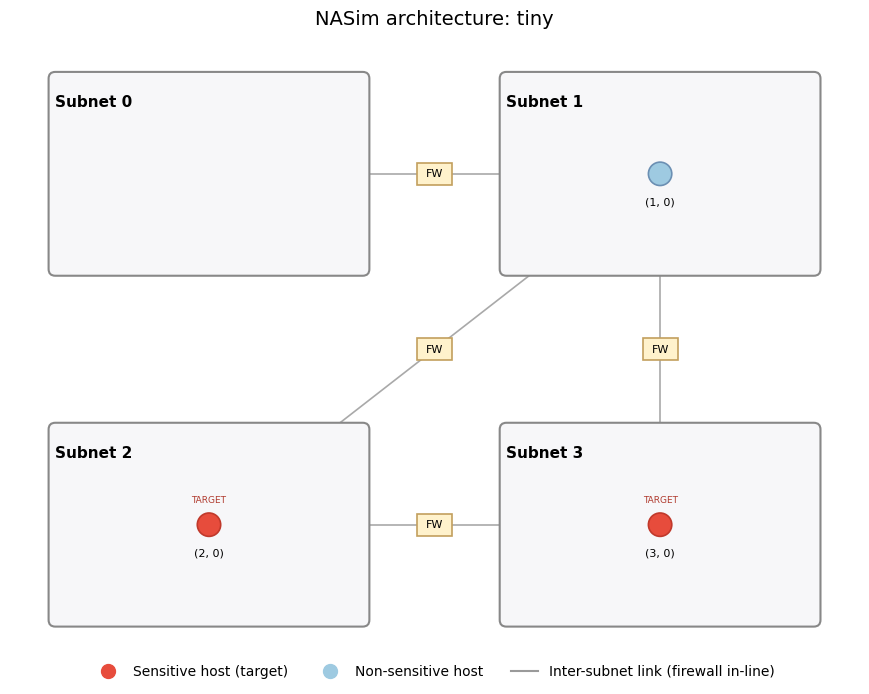

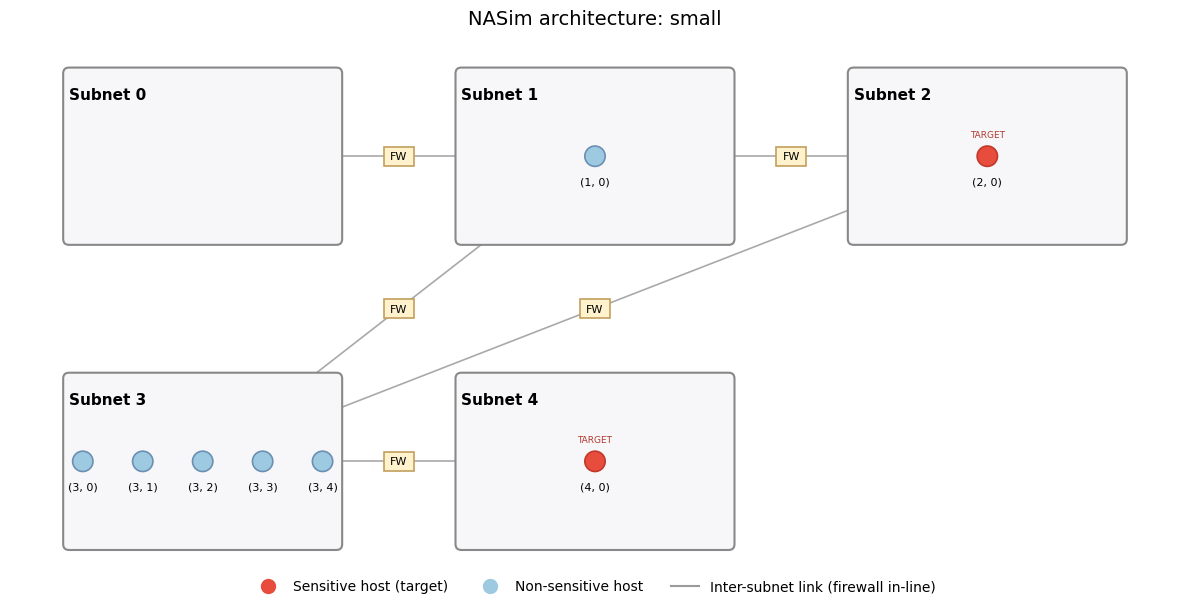

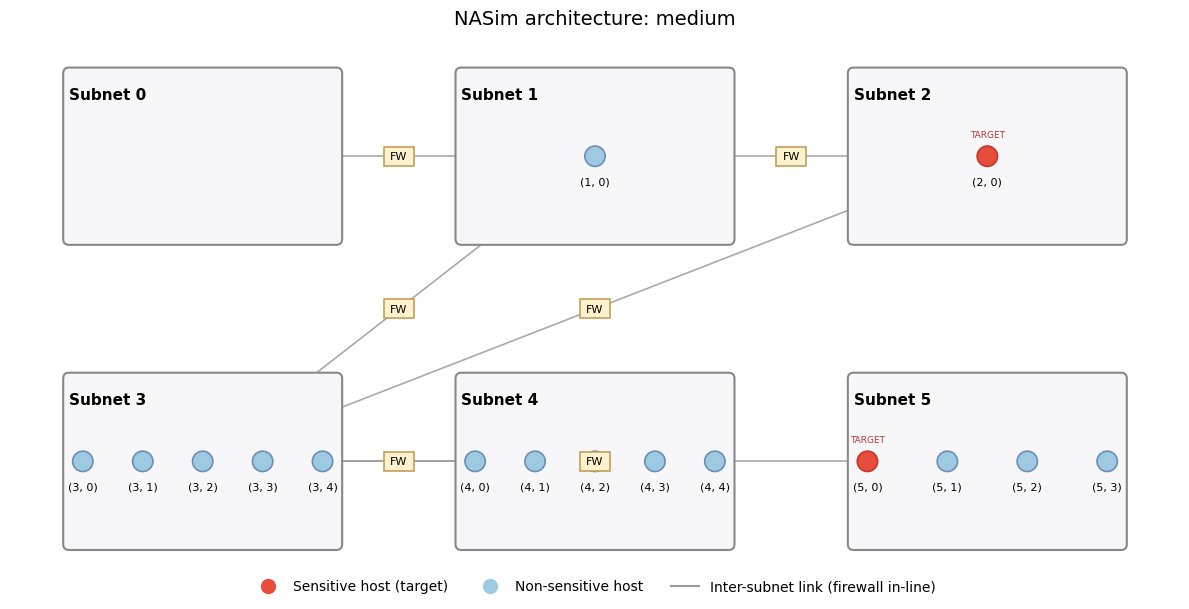

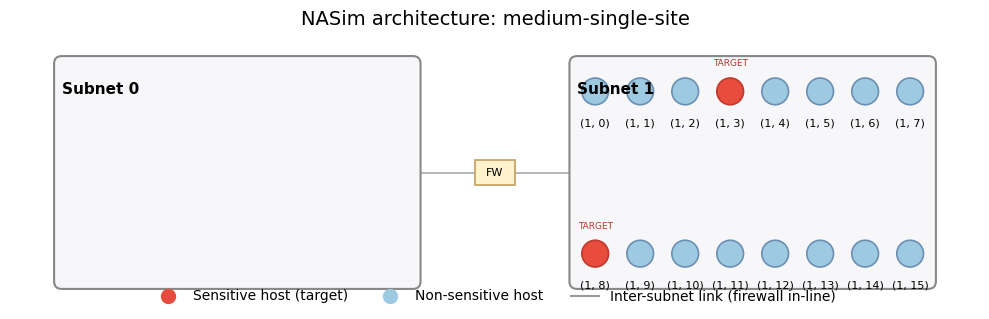

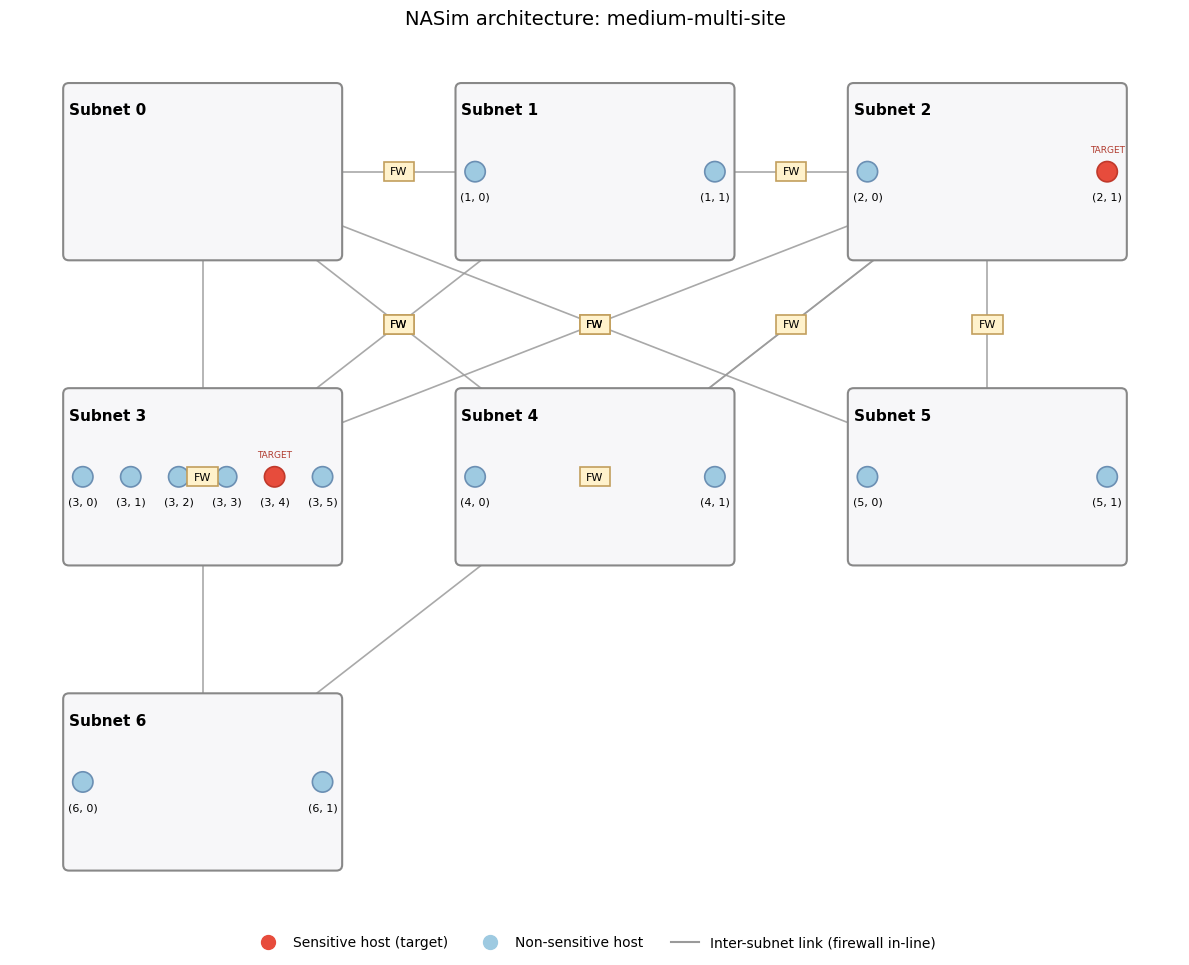

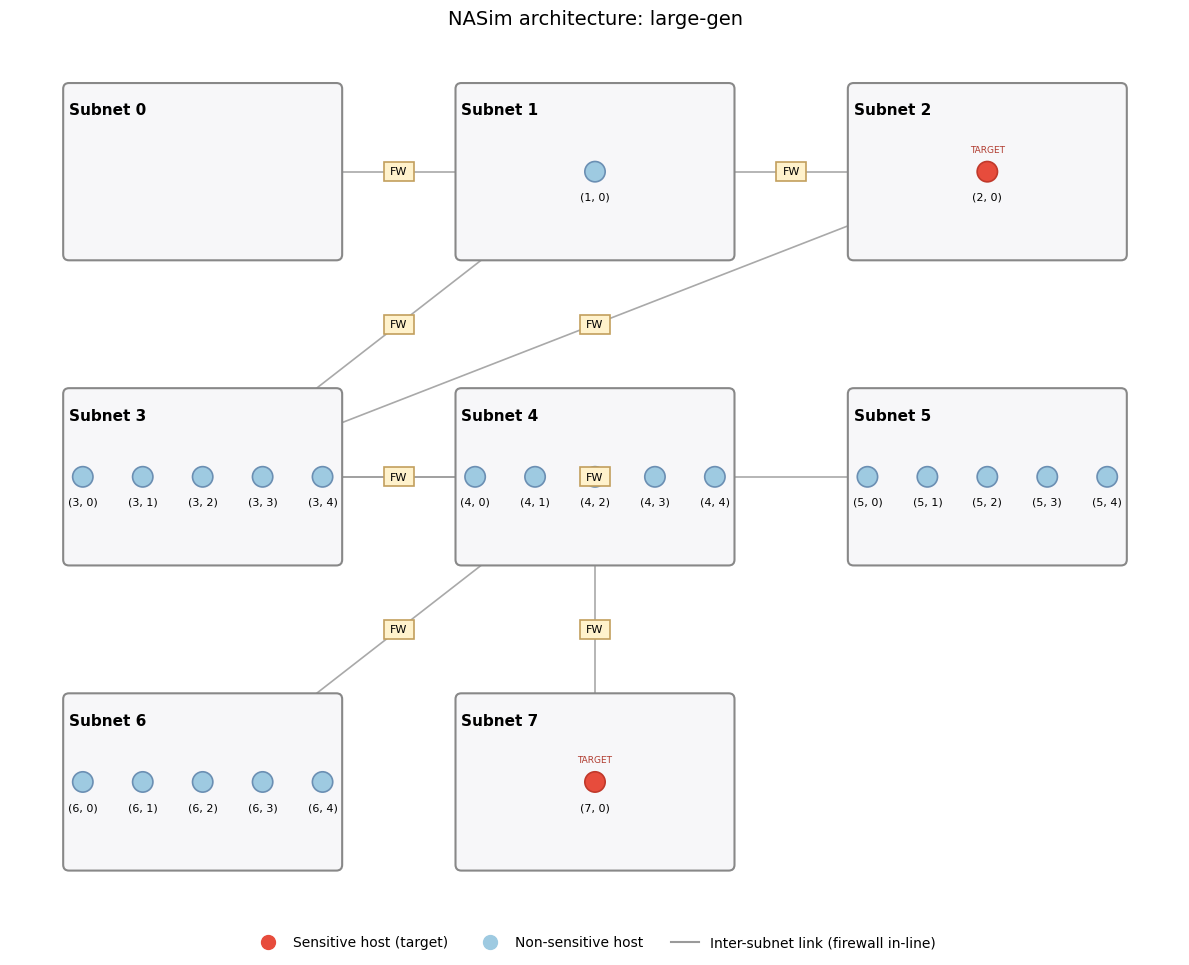

In [ ]:
# === NASim architecture diagrams (tiny/small/medium/.../large-gen) ===
# Copy–paste and run in a notebook or script.
# Requires: nasim, networkx, matplotlib

import math
import random
from typing import Dict, Tuple, List

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, FancyBboxPatch
import matplotlib.lines as mlines
import networkx as nx
import nasim

# -------- settings: add/remove environments you want to render ----------
ENVIRONMENTS = [
    "tiny",
    "small",
    "medium",
    "medium-single-site",
    "medium-multi-site",
    "large-gen",
]
SEED = 42          # layout repeatability
SAVE_PNG = False   # set True to save PNGs alongside showing them


def draw_nasim_architecture(env, seed: int = 42, title: str = None, save_png: bool = False):
    """
    Render a NASim scenario as a human-friendly architecture diagram:
      - Subnets as boxes (labeled)
      - Hosts as circles inside subnets (sensitive hosts in red)
      - 'Firewall' connectors between subnets where topology==1
    Works with current NASim API: env.scenario.{subnets, topology, hosts, sensitive_hosts/sensitive_addresses}
    """
    random.seed(seed)
    sc = env.scenario

    # --- pull core data, with fallbacks for different NASim versions ---
    subnets = list(sc.subnets)  # iterable of subnets; only len() is needed
    topology = sc.topology      # list-of-lists (or numpy array) over subnets
    hosts_dict: Dict[Tuple[int, int], object] = getattr(sc, "hosts", {})
    if not hosts_dict:
        raise RuntimeError("Scenario does not expose 'hosts' dict; update NASim or adapt mapping.")

    # sensitive addresses may be on sc.sensitive_addresses or keys of sensitive_hosts
    sensitive_addrs = set(
        getattr(sc, "sensitive_addresses", list(getattr(sc, "sensitive_hosts", {}).keys()))
    )

    # Group hosts by subnet index (addr is a tuple like (subnet_idx, host_idx))
    hosts_by_subnet: Dict[int, List[Tuple[int, int]]] = {}
    for addr in hosts_dict.keys():
        si = addr[0]
        hosts_by_subnet.setdefault(si, []).append(addr)

    n_subnets = len(subnets)
    if n_subnets == 0:
        raise ValueError("Scenario has no subnets to draw.")

    # --- figure layout: arrange subnets in a grid (roughly square) ---
    cols = math.ceil(math.sqrt(n_subnets))
    rows = math.ceil(n_subnets / cols)

    fig_w = max(10, cols * 4)
    fig_h = max(6, rows * 3.5)
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    ax.set_aspect('equal')
    ax.axis("off")

    # box sizes and spacing
    box_w, box_h = 3.8, 2.4
    x_gap, y_gap = 1.6, 1.8
    start_x, start_y = 1.0, 1.0

    # Compute subnet box positions
    subnet_boxes = {}  # si -> (x0, y0, w, h)
    for si in range(n_subnets):
        r = si // cols
        c = si % cols
        x0 = start_x + c * (box_w + x_gap)
        y0 = start_y + (rows - 1 - r) * (box_h + y_gap)
        subnet_boxes[si] = (x0, y0, box_w, box_h)

    # --- draw subnet boxes + labels ---
    for si, (x0, y0, w, h) in subnet_boxes.items():
        rect = FancyBboxPatch(
            (x0, y0), w, h,
            boxstyle="round,pad=0.02,rounding_size=0.08",
            linewidth=1.5, edgecolor="#888", facecolor="#f7f7f9"
        )
        ax.add_patch(rect)
        ax.text(x0 + 0.06, y0 + h - 0.25, f"Subnet {si}",
                fontsize=11, fontweight="bold", ha="left", va="top")

    # --- draw hosts inside subnet boxes ---
    node_radius = 0.14
    for si, hosts in hosts_by_subnet.items():
        # grid hosts in rows/cols inside the box
        x0, y0, w, h = subnet_boxes[si]
        # inner padding
        pad_x, pad_y = 0.25, 0.35
        inner_w, inner_h = w - 2*pad_x, h - 2*pad_y

        n = len(hosts)
        if n == 0:
            continue
        # columns so circles don't overlap; aim for ~4 per row
        cols_h = max(1, min(n, math.ceil(inner_w / (node_radius*3.2))))
        rows_h = math.ceil(n / cols_h)

        # spacing
        dx = 0 if cols_h == 1 else inner_w / (cols_h - 1)
        dy = 0 if rows_h == 1 else inner_h / (rows_h - 1)

        for idx, addr in enumerate(sorted(hosts, key=lambda a: a[1])):  # sort by host index
            r_idx = idx // cols_h
            c_idx = idx % cols_h
            cx = x0 + pad_x + (inner_w/2 if cols_h == 1 else dx * c_idx)
            cy = y0 + pad_y + (inner_h/2 if rows_h == 1 else inner_h - dy * r_idx)

            is_sensitive = addr in sensitive_addrs
            face = "#e74c3c" if is_sensitive else "#9ecae1"
            edge = "#c0392b" if is_sensitive else "#6b8fb3"

            circ = Circle((cx, cy), node_radius, facecolor=face, edgecolor=edge, linewidth=1.2)
            ax.add_patch(circ)
            ax.text(cx, cy - 0.28, f"{addr}", fontsize=8, ha="center", va="top")
            if is_sensitive:
                ax.text(cx, cy + 0.24, "TARGET", fontsize=6.5, ha="center", va="bottom", color="#b03a2e")

    # --- helper to read topology[i][j] robustly (list-of-lists or np.array) ---
    def topo(i, j):
        try:
            return bool(topology[i][j])
        except TypeError:
            return bool(topology[i, j])

    # --- draw "firewall" connectors between subnets that are connected ---
    for i in range(n_subnets):
        for j in range(i + 1, n_subnets):
            if not topo(i, j):
                continue
            # line between box centers
            x0_i, y0_i, w_i, h_i = subnet_boxes[i]
            x0_j, y0_j, w_j, h_j = subnet_boxes[j]
            xi, yi = x0_i + w_i/2, y0_i + h_i/2
            xj, yj = x0_j + w_j/2, y0_j + h_j/2

            # draw the inter-subnet link
            ax.plot([xi, xj], [yi, yj], color="#9a9a9a", linewidth=1.2, zorder=0, alpha=0.85)

            # place a small FW box at the midpoint
            mx, my = (xi + xj)/2, (yi + yj)/2
            fw_w, fw_h = 0.42, 0.26
            fw = Rectangle((mx - fw_w/2, my - fw_h/2), fw_w, fw_h,
                           facecolor="#fff2cc", edgecolor="#c29f5d", linewidth=1.2)
            ax.add_patch(fw)
            ax.text(mx, my, "FW", fontsize=8, ha="center", va="center")

    # --- legend and title ---
    red_patch = mlines.Line2D([], [], color='#e74c3c', marker='o', linestyle='None',
                              markersize=10, label='Sensitive host (target)')
    blue_patch = mlines.Line2D([], [], color='#9ecae1', marker='o', linestyle='None',
                               markersize=10, label='Non-sensitive host')
    fw_line = mlines.Line2D([], [], color='#9a9a9a', label='Inter-subnet link (firewall in-line)')
    ax.legend(handles=[red_patch, blue_patch, fw_line], loc='lower center', ncol=3,
              bbox_to_anchor=(0.5, -0.06), frameon=False)

    plt.title(title or f"NASim architecture: {env.name}", fontsize=14, pad=14)
    plt.tight_layout()
    if save_png:
        fname = f"nasim_arch_{env.name}.png".replace(" ", "_")
        plt.savefig(fname, dpi=180, bbox_inches="tight")
        print(f"Saved: {fname}")
    plt.show()


# --------- run for all requested environments ----------
for scen_name in ENVIRONMENTS:
    try:
        env = nasim.make_benchmark(scen_name)
        draw_nasim_architecture(env, seed=SEED, title=f"NASim architecture: {scen_name}",
                                save_png=SAVE_PNG)
    except Exception as e:
        print(f"[{scen_name}] skipped due to error: {e}")


/tmp/ipython-input-3163076509.py:306: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


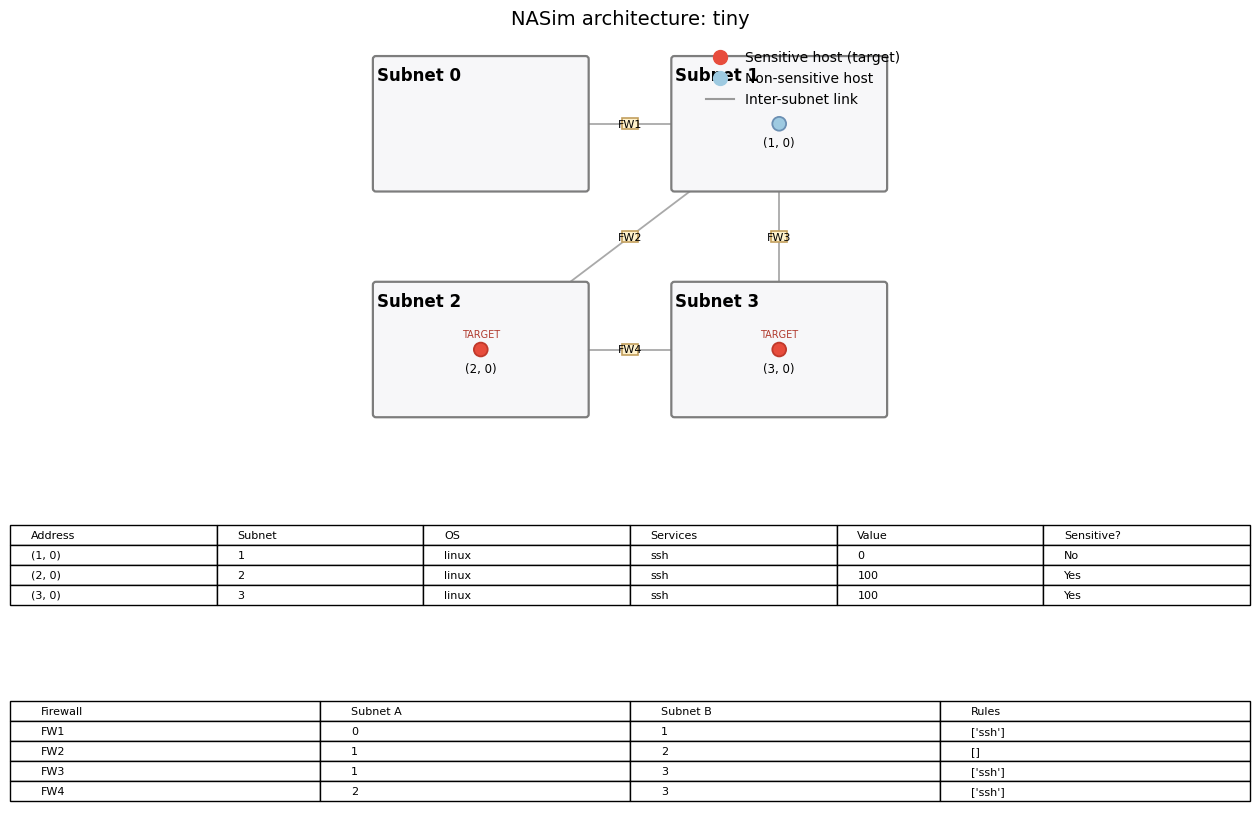

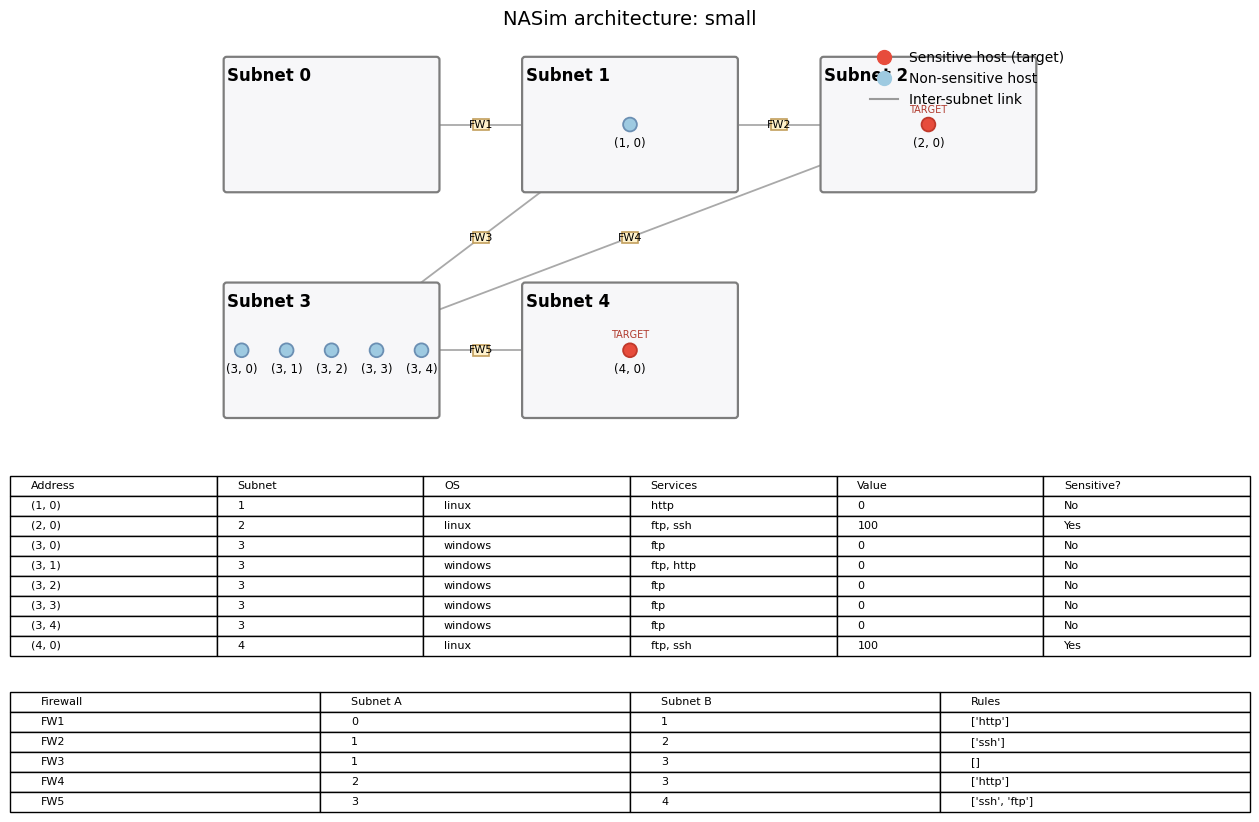

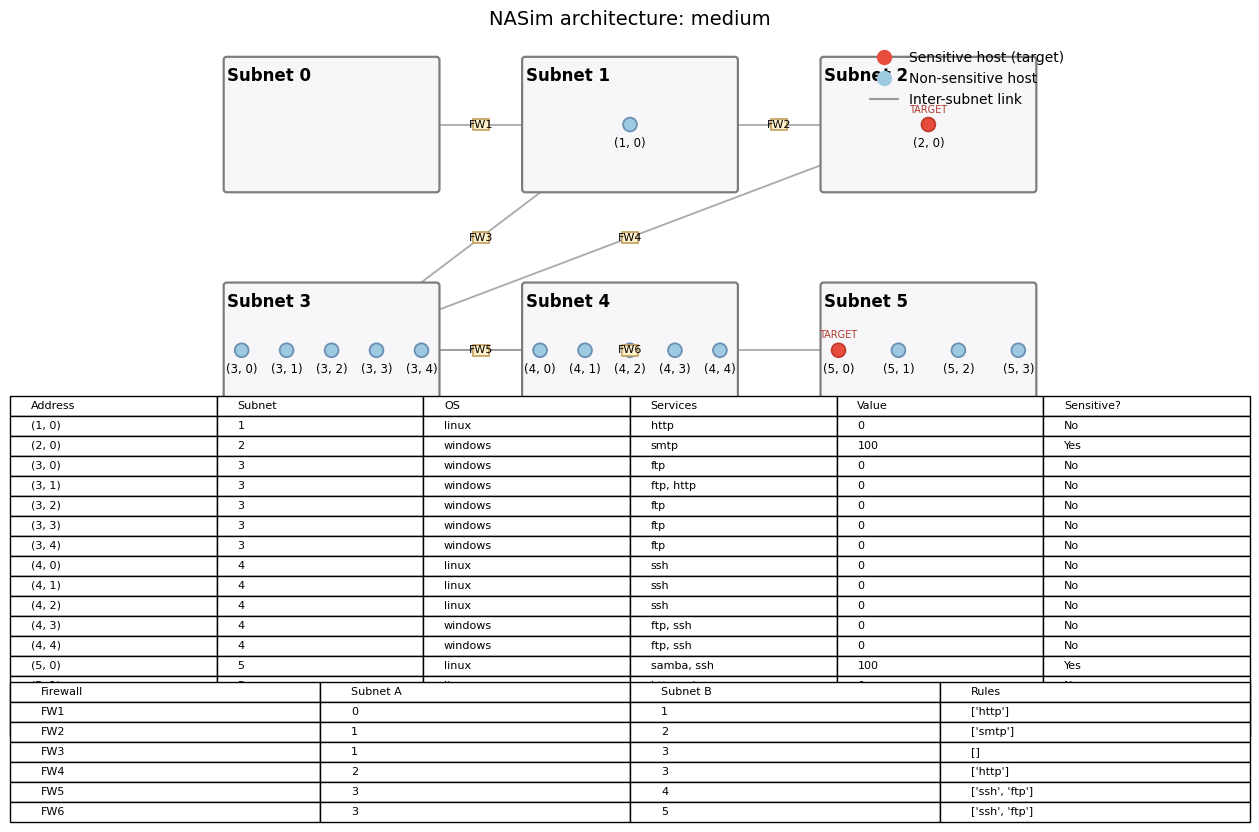

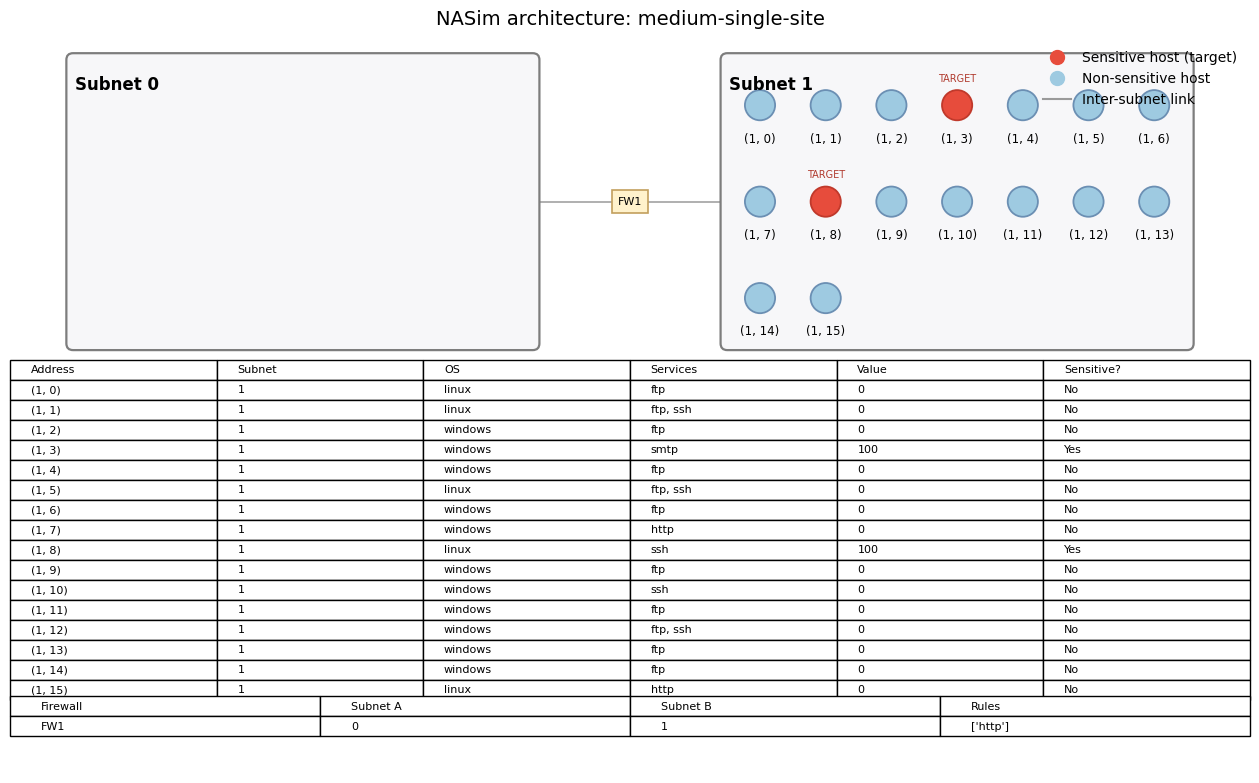

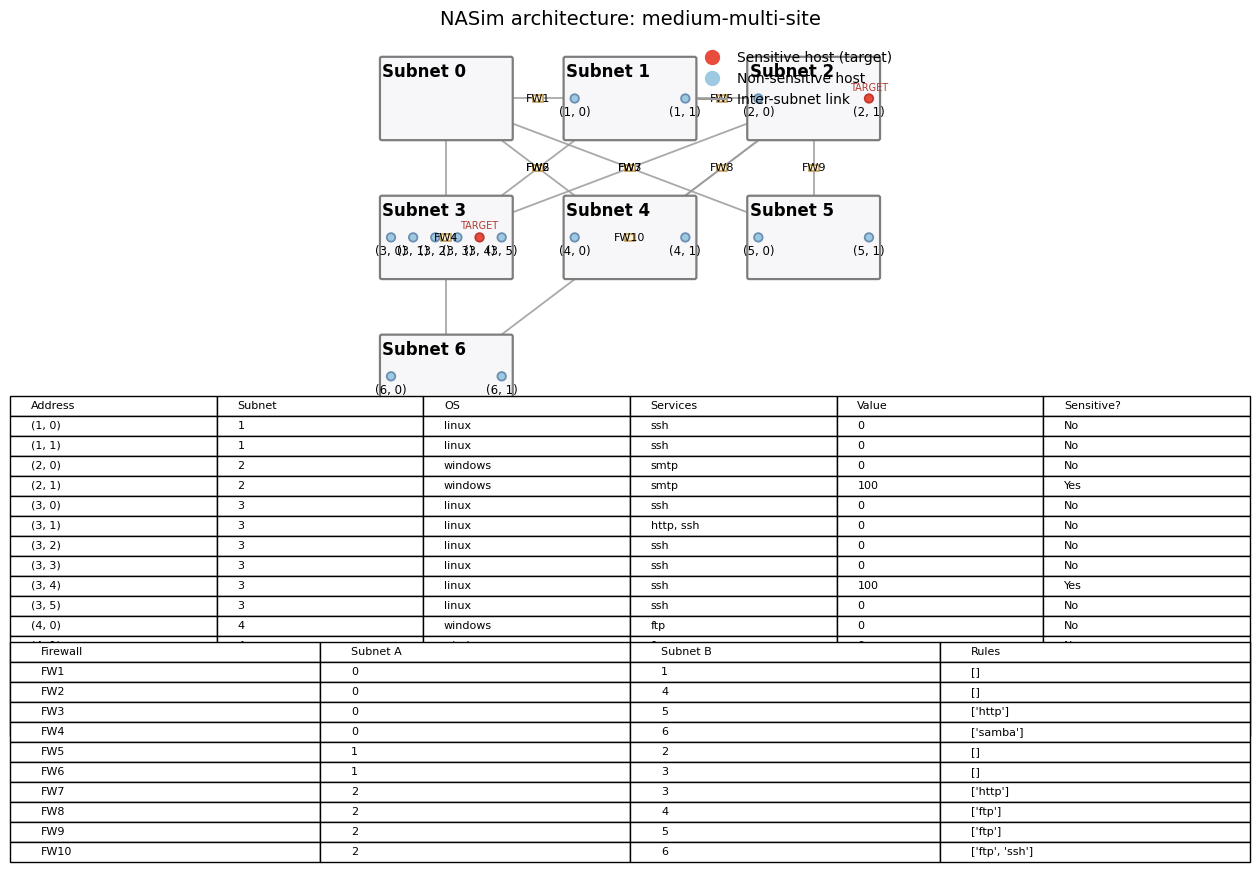

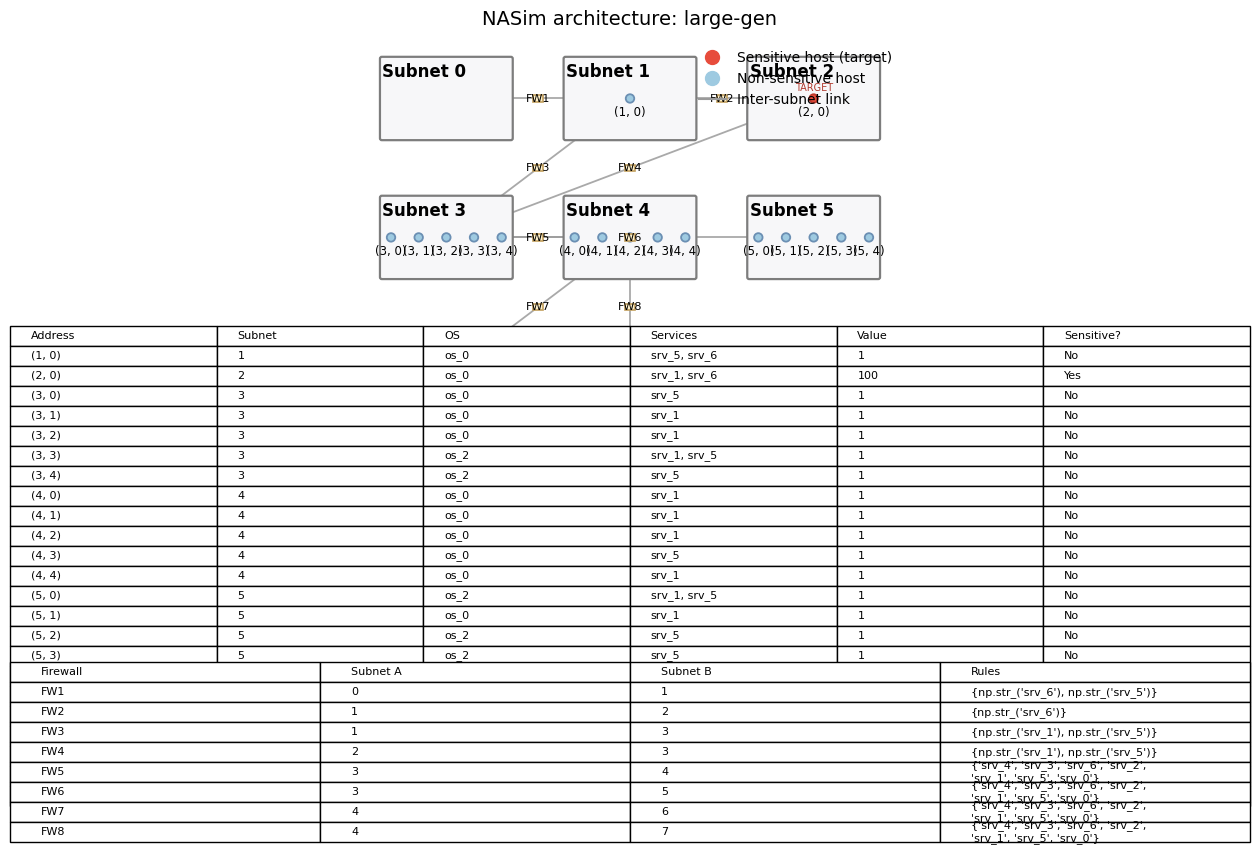

In [ ]:
# === NASim architecture with bottom tables: Hosts + Firewalls (FW1, FW2, …) ===
# Works for: tiny / small / medium / medium-single-site / medium-multi-site / large-gen
# Requires: nasim, networkx, matplotlib

import math
import textwrap
from typing import Dict, Tuple, List, Any

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, FancyBboxPatch
from matplotlib import gridspec
import matplotlib.lines as mlines
import networkx as nx
import nasim

# -------- environments to render ----------
ENVIRONMENTS = [
    "tiny",
    "small",
    "medium",
    "medium-single-site",
    "medium-multi-site",
    "large-gen",
]
SAVE_PNG = False   # True to save PNGs
WRAP_WIDTH_SERV = 38   # wrap width for Services column
WRAP_WIDTH_RULES = 40  # wrap width for Firewall rules column

# ---------- helpers ----------

def _get_sensitive_addrs(sc) -> set:
    if hasattr(sc, "sensitive_addresses") and sc.sensitive_addresses:
        return set(sc.sensitive_addresses)
    sh = getattr(sc, "sensitive_hosts", {}) or {}
    try:
        return set(sh.keys())
    except Exception:
        return set()

def _get_host_obj(sc, addr):
    return (getattr(sc, "hosts", {}) or {}).get(addr)

def _as_list(x):
    if x is None:
        return []
    if isinstance(x, dict):
        return sorted([k for k, v in x.items() if bool(v)])
    if isinstance(x, (list, tuple, set)):
        return sorted(list(x))
    return [str(x)]

def _try_fields(obj: Any, names: List[str], default=None):
    for n in names:
        if hasattr(obj, n):
            val = getattr(obj, n)
            if val is not None:
                return val
    return default

def _fmt_os(os_val) -> str:
    if isinstance(os_val, dict):
        # e.g., {'linux': True, 'windows': False} -> 'linux'
        for k, v in os_val.items():
            if v: return str(k)
        return "/".join([k for k, v in os_val.items() if v]) or "unknown"
    return "unknown" if os_val is None else str(os_val)

def _fmt_val(value) -> str:
    if value is None:
        return "—"
    try:
        ival = int(value)
        if float(value) == float(ival):
            return str(ival)
    except Exception:
        pass
    return str(value)

def _host_info(sc, addr) -> Dict[str, Any]:
    """Return dict with os, services, value for a host address (subnet, host)."""
    h = _get_host_obj(sc, addr)

    os_val = None
    if h is not None:
        os_val = _try_fields(h, ["os", "OS", "ostype", "os_type"])
    if os_val is None:
        for name in ["host_os", "hosts_os", "os_map", "os_by_host"]:
            mp = getattr(sc, name, None)
            if isinstance(mp, dict) and addr in mp:
                os_val = mp[addr]; break

    services = []
    if h is not None:
        services = _as_list(_try_fields(h, [
            "services", "open_services", "service_states", "svc", "svcs"
        ], default=[]))
    if not services:
        for name in ["host_services", "services_by_host", "service_map"]:
            mp = getattr(sc, name, None)
            if isinstance(mp, dict) and addr in mp:
                services = _as_list(mp[addr]); break

    value = None
    sh = getattr(sc, "sensitive_hosts", {}) or {}
    if isinstance(sh, dict) and addr in sh: value = sh[addr]
    if value is None and h is not None:
        value = _try_fields(h, ["value", "reward", "val"])

    return {
        "os": _fmt_os(os_val),
        "services": services,
        "value": _fmt_val(value),
    }

def _fw_rules_between(sc, si: int, sj: int) -> str:
    # Try common attributes if your scenario defines ACLs; default "any"
    for name in ["firewall", "fw", "acl", "acls", "firewall_rules", "fw_rules"]:
        fw = getattr(sc, name, None)
        if isinstance(fw, dict):
            if (si, sj) in fw: return str(fw[(si, sj)])
            if (sj, si) in fw: return str(fw[(sj, si)])
            if si in fw and isinstance(fw[si], dict) and sj in fw[si]: return str(fw[si][sj])
            if sj in fw and isinstance(fw[sj], dict) and si in fw[sj]: return str(fw[sj][si])
    return "any"

def _wrap(txt: str, width: int) -> str:
    if not txt: return ""
    return "\n".join(textwrap.wrap(txt, width=width))

# --------------- main drawing ---------------

def draw_nasim_architecture_with_tables(env, title: str = None, save_png: bool = False):
    sc = env.scenario
    subnets = list(sc.subnets)
    topology = sc.topology
    hosts_dict: Dict[Tuple[int, int], object] = getattr(sc, "hosts", {}) or {}
    if not hosts_dict:
        raise RuntimeError("Scenario has no 'hosts' mapping; update NASim or adapt.")
    sensitive_addrs = _get_sensitive_addrs(sc)

    # Group hosts by subnet
    hosts_by_subnet: Dict[int, List[Tuple[int, int]]] = {}
    for addr in hosts_dict.keys():
        hosts_by_subnet.setdefault(addr[0], []).append(addr)

    n_subnets = len(subnets)
    if n_subnets == 0:
        raise ValueError("Scenario has no subnets.")

    # Build firewall link list (and we’ll label FW1, FW2, …)
    def topo(i, j):
        try: return bool(topology[i][j])
        except TypeError: return bool(topology[i, j])

    fw_links: List[Tuple[str, int, int, str]] = []  # (FW#, si, sj, rules)

    # --- Figure layout: use GridSpec (big top diagram + two tables below) ---
    fig = plt.figure(figsize=(16, 10))
    gs = gridspec.GridSpec(3, 2, height_ratios=[3.5, 1.0, 1.0], hspace=0.35, wspace=0.2)

    ax_top = fig.add_subplot(gs[0, :])   # main diagram (spans both columns)
    ax_hosts_tbl = fig.add_subplot(gs[1, :])  # host table (spans both columns)
    ax_fw_tbl = fig.add_subplot(gs[2, :])     # firewall table (spans both columns)

    # -------------------- TOP DIAGRAM --------------------
    ax_top.set_aspect('equal')
    ax_top.axis("off")

    # Subnet grid in top diagram
    cols = math.ceil(math.sqrt(n_subnets))
    rows = math.ceil(n_subnets / cols)
    box_w, box_h = 5.6, 3.5
    x_gap, y_gap = 2.2, 2.4
    start_x, start_y = 1.0, 1.0

    subnet_boxes = {}  # si -> (x0, y0, w, h)
    for si in range(n_subnets):
        r = si // cols
        c = si % cols
        x0 = start_x + c * (box_w + x_gap)
        y0 = start_y + (rows - 1 - r) * (box_h + y_gap)
        subnet_boxes[si] = (x0, y0, box_w, box_h)

    # Draw subnet boxes
    for si, (x0, y0, w, h) in subnet_boxes.items():
        rect = FancyBboxPatch((x0, y0), w, h,
                              boxstyle="round,pad=0.02,rounding_size=0.08",
                              linewidth=1.6, edgecolor="#7d7d7d", facecolor="#f7f7f9")
        ax_top.add_patch(rect)
        ax_top.text(x0 + 0.08, y0 + h - 0.25, f"Subnet {si}",
                    fontsize=12, fontweight="bold", ha="left", va="top")

    # Draw hosts (circles + labels) — keep diagram clean; details go in table below
    node_r = 0.18
    for si, hosts in hosts_by_subnet.items():
        x0, y0, w, h = subnet_boxes[si]
        pad_x, pad_y = 0.45, 0.60
        inner_w, inner_h = w - 2*pad_x, h - 2*pad_y

        n = len(hosts)
        if n == 0:
            continue
        cols_h = max(1, min(n, math.ceil(inner_w / (node_r * 4.2))))
        rows_h = math.ceil(n / cols_h)
        dx = 0 if cols_h == 1 else inner_w / (cols_h - 1)
        dy = 0 if rows_h == 1 else inner_h / (rows_h - 1)

        for idx, addr in enumerate(sorted(hosts, key=lambda a: a[1])):
            r_idx = idx // cols_h
            c_idx = idx % cols_h
            cx = x0 + pad_x + (inner_w/2 if cols_h == 1 else dx * c_idx)
            cy = y0 + pad_y + (inner_h/2 if rows_h == 1 else inner_h - dy * r_idx)

            is_sensitive = addr in sensitive_addrs
            face = "#e74c3c" if is_sensitive else "#9ecae1"
            edge = "#c0392b" if is_sensitive else "#6b8fb3"

            circ = Circle((cx, cy), node_r, facecolor=face, edgecolor=edge, linewidth=1.3)
            ax_top.add_patch(circ)
            ax_top.text(cx, cy - 0.32, f"{addr}", fontsize=8.5, ha="center", va="top")
            if is_sensitive:
                ax_top.text(cx, cy + 0.26, "TARGET", fontsize=7, ha="center", va="bottom", color="#b03a2e")

    # Inter-subnet links + FW labels
    fw_idx = 1
    for i in range(n_subnets):
        for j in range(i + 1, n_subnets):
            if not topo(i, j):
                continue
            x0_i, y0_i, w_i, h_i = subnet_boxes[i]
            x0_j, y0_j, w_j, h_j = subnet_boxes[j]
            xi, yi = x0_i + w_i/2, y0_i + h_i/2
            xj, yj = x0_j + w_j/2, y0_j + h_j/2

            ax_top.plot([xi, xj], [yi, yj], color="#9a9a9a", linewidth=1.3, zorder=0, alpha=0.85)

            mx, my = (xi + xj)/2, (yi + yj)/2
            label = f"FW{fw_idx}"
            ax_top.add_patch(Rectangle((mx - 0.42/2, my - 0.28/2), 0.42, 0.28,
                                       facecolor="#fff2cc", edgecolor="#c29f5d", linewidth=1.2))
            ax_top.text(mx, my, label, fontsize=8, ha="center", va="center")

            rules = _fw_rules_between(sc, i, j)
            rules_txt = ", ".join(list(rules)[:12]) if isinstance(rules, (list, tuple, set)) else str(rules)
            fw_links.append((label, i, j, rules_txt))
            fw_idx += 1

    # legend + title
    red_patch = mlines.Line2D([], [], color='#e74c3c', marker='o', linestyle='None',
                              markersize=10, label='Sensitive host (target)')
    blue_patch = mlines.Line2D([], [], color='#9ecae1', marker='o', linestyle='None',
                               markersize=10, label='Non-sensitive host')
    fw_line = mlines.Line2D([], [], color='#9a9a9a', label='Inter-subnet link')
    ax_top.legend(handles=[red_patch, blue_patch, fw_line], loc='upper right', frameon=False)

    ax_top.set_title(title or f"NASim architecture: {env.name}", fontsize=14, pad=10)

    # -------------------- HOST TABLE (bottom) --------------------
    ax_hosts_tbl.axis("off")

    # Build host rows
    host_rows = []
    headers_hosts = ["Address", "Subnet", "OS", "Services", "Value", "Sensitive?"]
    for addr in sorted(hosts_dict.keys(), key=lambda a: (a[0], a[1])):
        info = _host_info(sc, addr)
        services_txt = ", ".join(info["services"]) if info["services"] else "—"
        services_txt = _wrap(services_txt, WRAP_WIDTH_SERV)
        host_rows.append([
            str(addr),
            str(addr[0]),
            _fmt_os(info["os"]),
            services_txt,
            info["value"],
            "Yes" if addr in sensitive_addrs else "No",
        ])

    # Render host table
    tbl_hosts = ax_hosts_tbl.table(cellText=host_rows, colLabels=headers_hosts,
                                   cellLoc='left', colLoc='left', loc='center')
    tbl_hosts.auto_set_font_size(False)
    tbl_hosts.set_fontsize(8)
    tbl_hosts.scale(1.0, 1.2)

    # -------------------- FIREWALL TABLE (bottom) --------------------
    ax_fw_tbl.axis("off")

    headers_fw = ["Firewall", "Subnet A", "Subnet B", "Rules"]
    fw_rows = []
    for label, si, sj, rules in fw_links:
        fw_rows.append([
            label,
            str(si),
            str(sj),
            _wrap(str(rules), WRAP_WIDTH_RULES) if rules else "any"
        ])

    if not fw_rows:
        fw_rows = [["—", "—", "—", "No inter-subnet links"]]

    tbl_fw = ax_fw_tbl.table(cellText=fw_rows, colLabels=headers_fw,
                             cellLoc='left', colLoc='left', loc='center')
    tbl_fw.auto_set_font_size(False)
    tbl_fw.set_fontsize(8)
    tbl_fw.scale(1.0, 1.2)

    plt.tight_layout()
    if save_png:
        fname = f"nasim_arch_tables_{env.name}.png".replace(" ", "_")
        plt.savefig(fname, dpi=180, bbox_inches="tight")
        print(f"Saved: {fname}")
    plt.show()


# --------- run for all requested environments ----------
for scen_name in ENVIRONMENTS:
    try:
        env = nasim.make_benchmark(scen_name)
        draw_nasim_architecture_with_tables(env, title=f"NASim architecture: {scen_name}",
                                            save_png=SAVE_PNG)
    except Exception as e:
        print(f"[{scen_name}] skipped due to error: {e}")
